# Manual and automated ELA picks: Make figures for AGU

In [3]:
pip install contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 74.8 MB/s eta 0:00:00


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import numpy as np
import geopandas as gpd
import seaborn as sns
from tqdm.auto import tqdm
import contextily as ctx
from scipy.stats import iqr

In [5]:
#If using Google Colab, mount Google Drive so you can access the files in this folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# RAINEY'S PATH TO SNOW_COVER_MAPPING_APPLICATION
#base_path = '/Users/raineyaberle/Google Drive/My Drive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/'

# ALEXANDRA'S PATH TO SNOW_COVER_MAPPING_APPLICATION
base_path = '/content/drive/MyDrive/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/'

# path for output figures
figures_out_path = os.path.join(base_path, 'figures')

## Define function for determining each subregion's name and color

In [7]:
def determine_subregion_name_color(o1, o2):
    if (o1 == 1.0) and (o2 == 1.0):
        subregion_name, color = 'Brooks Range', 'c'
    elif (o1 == 1.0) and (o2 == 2.0):
        subregion_name, color = 'Alaska Range', '#1f78b4'
    elif (o1 == 1.0) and (o2 == 3.0):
        subregion_name, color = 'Aleutians', '#6d9c43'
    elif (o1 == 1.0) and (o2 == 4.0):
        subregion_name, color = 'W. Chugach Mtns.', '#264708'
    elif (o1 == 1.0) and (o2 == 5.0):
        subregion_name, color = 'St. Elias Mtns.', '#fb9a99'
    elif (o1 == 1.0) and (o2 == 6.0):
        subregion_name, color = 'N. Coast Ranges', '#e31a1c'
    elif (o1 == 2.0) and (o2 == 1.0):
        subregion_name, color = 'N. Rockies', '#cab2d6'
    elif (o1 == 2.0) and (o2 == 2.0):
        subregion_name, color = 'N. Cascades', '#fdbf6f'
    elif (o1 == 2.0) and (o2 == 3.0):
        subregion_name, color = 'C. Rockies', '#9657d9'
    elif (o1 == 2.0) and (o2 == 4.0):
        subregion_name, color = 'S. Cascades', '#ff7f00'
    elif (o1 == 2.0) and (o2 == 5.0):
        subregion_name, color = 'S. Rockies', '#6a3d9a'
    else:
        subregion_name = 'O1:' + o1 + ' O2:' + o2
        color = 'k'

    return subregion_name, color

## Plot ELA time series and Meteorological data

In [10]:
# Load ELA training data
elas_fn = 'ELA_training_data.csv'
elas = pd.read_csv(os.path.join(base_path, 'snow-cover-mapping-application', 'inputs-outputs', elas_fn))
elas['datetime'] = pd.to_datetime(elas['datetime']) # put all dates in datetime format
elas[['O1Region', 'O2Region']] = elas[['O1Region', 'O2Region']].astype(float)

# Load met data
precip_fn = 'Precip_time_series_AK.csv'
precip_data = pd.read_csv(os.path.join(base_path, precip_fn))
temp_fn = '2m_air_temperature_anomaly_time_series_AK.csv'
temp_data = pd.read_csv(os.path.join(base_path, temp_fn))

# Identify unique subregions
unique_subregions = elas[['O1Region', 'O2Region']].drop_duplicates().sort_values(by=['O1Region', 'O2Region'])
unique_subregions.reset_index(drop=True, inplace=True)
unique_subregions

,O1Region,O2Region
0,1.0,2.0
1,1.0,3.0
2,1.0,4.0
3,1.0,5.0
4,1.0,6.0
5,2.0,1.0
6,2.0,2.0
7,2.0,3.0
8,2.0,4.0


## Version 1: boxplots for AARs and ELAs and met data

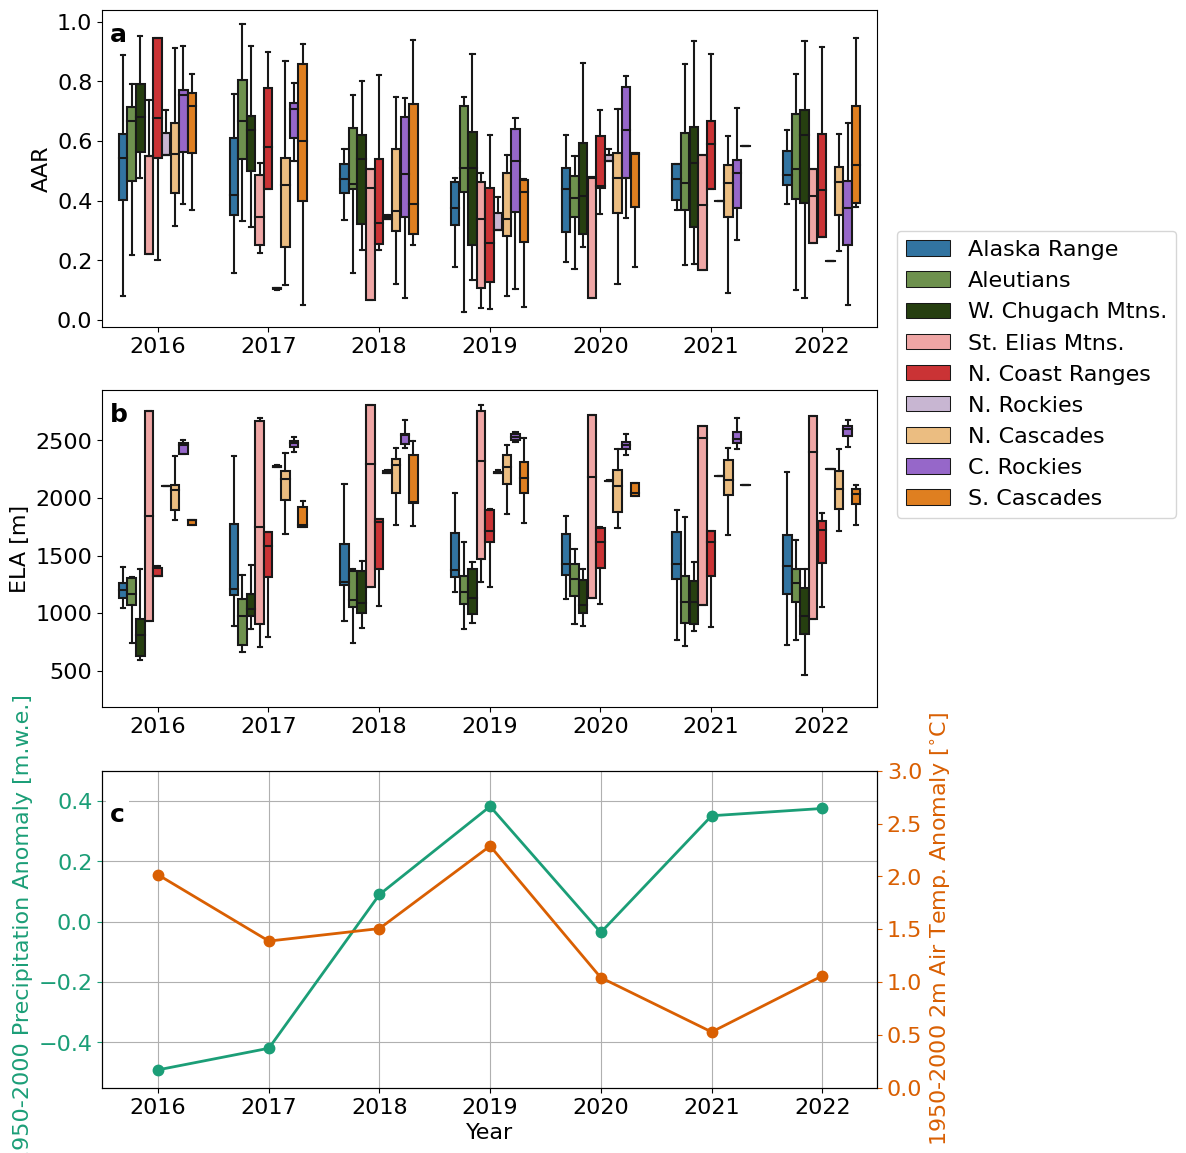

figure saved to file: /content/drive/MyDrive/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/figures/AARs_ELAs_boxplots_met_data.png


In [11]:
# -----Set up figure
plt.rcParams.update({'font.size':16, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(3, 1, figsize=(10,14))
ax2 = ax[2].twinx()
xrange = [np.datetime64('2015-11-01'), np.datetime64('2022-12-01')]

# -----ELA time series
# add year column
elas['Year'] = elas['datetime'].values.astype('datetime64[Y]').astype(int) + 1970
# add subregion name and color columns to elas
elas[['Subregion', 'Color']] = '', ''
for o1region, o2region in unique_subregions.values:
    subregion_name, color = determine_subregion_name_color(o1region, o2region)
    elas.loc[(elas['O1Region']==o1region) & (elas['O2Region']==o2region), 'Subregion'] = subregion_name
    elas.loc[(elas['O1Region']==o1region) & (elas['O2Region']==o2region), 'Color'] = color
elas.sort_values(by=['O1Region', 'O2Region'], inplace=True)
# define palette for subregions
palette = elas[['O1Region', 'O2Region', 'Subregion', 'Color']].drop_duplicates()
palette = dict(palette[['Subregion', 'Color']].values)
# plot boxplots
bp1 = sns.boxplot(data=elas, x='Year', y='AAR', ax=ax[0], hue='Subregion',
                  palette=palette, fliersize=0, width=0.7)
bp2 = sns.boxplot(data=elas, x='Year', y='snowline_elevs_median_m', ax=ax[1], hue='Subregion',
                  palette=palette, fliersize=0, width=0.7)
# adjust axes
ax[0].set_xlabel('')
ax[0].set_ylabel('AAR')
# ax[0].yaxis.grid()
ax[1].set_xlabel('')
ax[1].set_ylabel('ELA [m]')
# ax[1].yaxis.grid()
# adjust legend
ax[0].legend(loc='center right', bbox_to_anchor=[1.2, -0.25, 0.2, 0.2])
ax[1].get_legend().remove()

# -----Meteorological Data
# define axes settings
colors = ['#1b9e77', '#d95f02']  # colors for plotting and labeling each variable
yaxis_labels = ['1950-2000 Precipitation Anomaly [m.w.e.]', '1950-2000 2m Air Temp. Anomaly [$^{\circ}$C]']
# -----Iterate over met. variables
for data, axis, color, yaxis_label in list(zip([precip_data, temp_data],
                                               [ax[2], ax2],
                                               colors,
                                               yaxis_labels)):
    # Restructure dataframe so dates are in one column, precipitation is in another column
    data['Year'] = data['Year'].astype(str)
    data_restruct = pd.DataFrame()
    columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    # iterate over month columns
    for i, column in enumerate(columns):
        # grab month number
        if i+1 < 10:
            month = '0' + str(i+1)
        else:
            month = str(i+1)
        # grab dates and precipitation values for month
        dates = [np.datetime64(year + '-' + month + '-01') for year in data['Year'].values]
        data_values = data[column].values
        # compile into dataframe
        df = pd.DataFrame({'Date': dates, 'Values': data_values})
        # concatenate to full dataframe
        data_restruct = pd.concat([data_restruct, df])
    # Remove no data values
    data_restruct = data_restruct.drop(data_restruct[data_restruct['Values'] <= -999].index)
    # Sort by date and renumber indices
    data_restruct.sort_values(by='Date', inplace=True)
    data_restruct.reset_index(drop=True, inplace=True)
    # calculate yearly mean
    yearly_mean = data_restruct.groupby(data_restruct['Date'].dt.year)['Values'].mean()
    # only include years starting in 2016
    yearly_mean = yearly_mean.iloc[yearly_mean.index >= 2016]
    dates = [np.datetime64(str(year) + '-01-01') for year in yearly_mean.index]
    # Plot
    axis.plot(dates, yearly_mean.values, '.-', color=color, markersize=15, linewidth=2)
    # adjust axes
    axis.set_ylabel(yaxis_label, color=color)
    axis.tick_params(axis='y', colors=color)
    # axis.spines[yaxis_side].set_color(color)
    axis.set_xlim(np.datetime64('2015-07-01'), np.datetime64('2022-07-01'))

# add text labels
labels = ['a', 'b', 'c']
for axis, label in zip(ax, labels):
    axis.text((axis.get_xlim()[1] - axis.get_xlim()[0]) * 0.01 + axis.get_xlim()[0],
              (axis.get_ylim()[1] - axis.get_ylim()[0]) * 0.9 + axis.get_ylim()[0],
              label, bbox=dict(facecolor='white', edgecolor='None', pad=3), fontsize=18, fontweight='bold')

ax[2].set_xlabel('Year')
ax[2].grid()
ax[2].set_ylim(-0.55, 0.5)
ax2.set_ylim(0, 3)
plt.show()

# save figure
fig_fn = os.path.join(figures_out_path, 'AARs_ELAs_boxplots_met_data.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('figure saved to file: ' + fig_fn)

## Version 2: median ELAs and AARs and met data

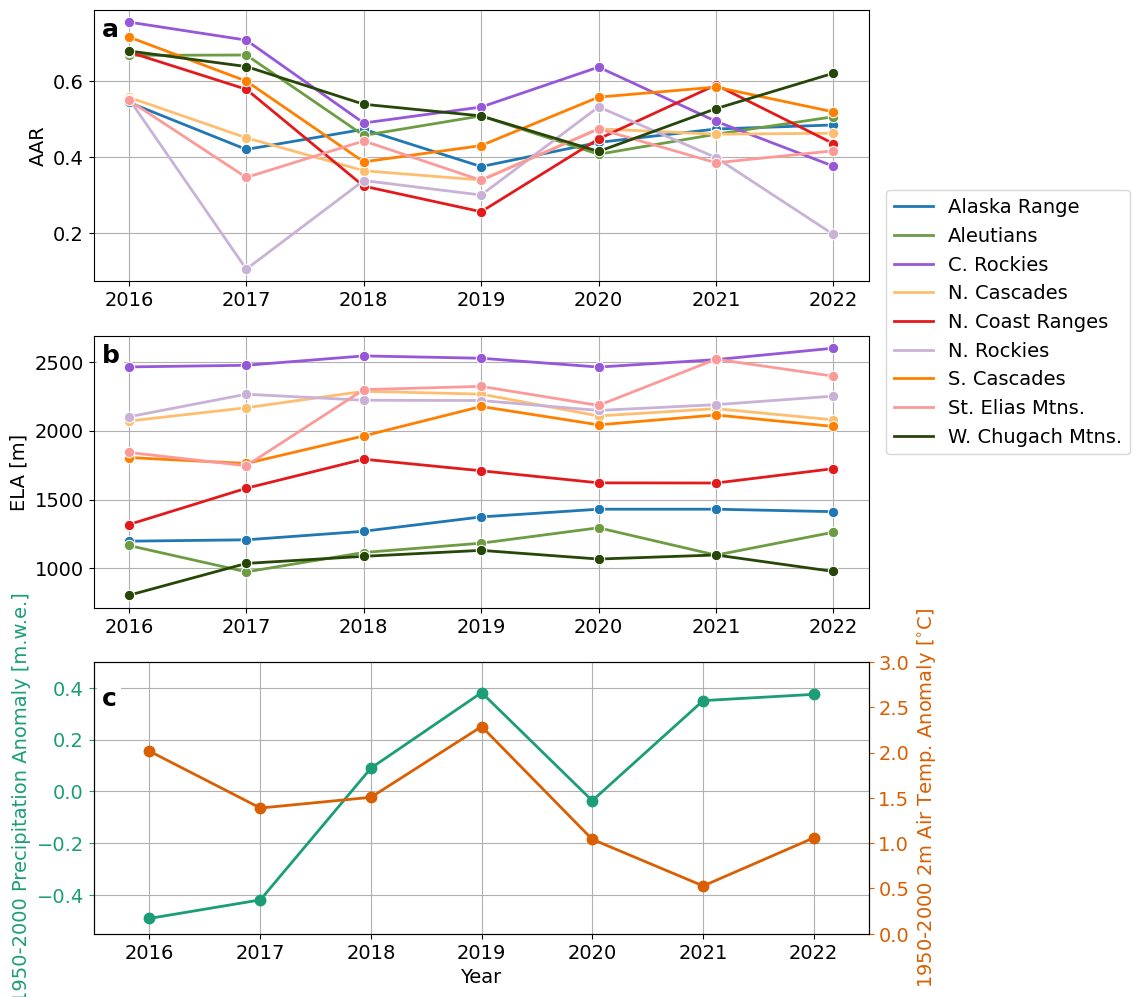

figure saved to file: /content/drive/MyDrive/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/figures/AARs_ELAs_median_lineplot_met_data.png


In [12]:
# -----Set up figure
plt.rcParams.update({'font.size':14, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(3, 1, figsize=(10,12))
ax2 = ax[2].twinx()
xrange = [np.datetime64('2015-11-01'), np.datetime64('2022-12-01')]

# -----ELA time series
# add year column
elas['Year'] = elas['datetime'].values.astype('datetime64[Y]').astype(int) + 1970
# add subregion name and color columns to elas
elas[['Subregion', 'Color']] = '', ''
for o1region, o2region in unique_subregions.values:
    subregion_name, color = determine_subregion_name_color(o1region, o2region)
    elas.loc[(elas['O1Region']==o1region) & (elas['O2Region']==o2region), 'Subregion'] = subregion_name
    elas.loc[(elas['O1Region']==o1region) & (elas['O2Region']==o2region), 'Color'] = color
elas.sort_values(by=['O1Region', 'O2Region'], inplace=True)
# define palette for subregions
palette = elas[['O1Region', 'O2Region', 'Subregion', 'Color']].drop_duplicates()
palette = dict(palette[['Subregion', 'Color']].values)
# plot lineplot of median trends
linewidth = 2
markersize = 15
sns.lineplot(data=elas.groupby(['Year', 'Subregion'])['AAR'].median().reset_index(), x='Year', y='AAR',
             hue='Subregion', palette=palette, ax=ax[0], marker='.', linewidth=linewidth, markersize=markersize)
sns.lineplot(data=elas.groupby(['Year', 'Subregion'])['snowline_elevs_median_m'].median().reset_index(), x='Year', y='snowline_elevs_median_m',
             hue='Subregion', palette=palette, ax=ax[1], marker='.', linewidth=linewidth, markersize=markersize)

# adjust axes
ax[0].set_xlabel('')
ax[0].set_ylabel('AAR')
ax[0].grid()
ax[1].set_xlabel('')
ax[1].set_ylabel('ELA [m]')
ax[1].grid()
# adjust legend
leg = ax[0].legend(loc='center right', bbox_to_anchor=[1.15, -0.25, 0.2, 0.2], markerscale=2)
for line in leg.get_lines():
    line.set_linewidth(linewidth)
ax[1].get_legend().remove()

# -----Meteorological Data
# define axes settings
colors = ['#1b9e77', '#d95f02']  # colors for plotting and labeling each variable
yaxis_labels = ['1950-2000 Precipitation Anomaly [m.w.e.]', '1950-2000 2m Air Temp. Anomaly [$^{\circ}$C]']
# -----Iterate over met. variables
for data, axis, color, yaxis_label in list(zip([precip_data, temp_data],
                                               [ax[2], ax2],
                                               colors,
                                               yaxis_labels)):
    # Restructure dataframe so dates are in one column, precipitation is in another column
    data['Year'] = data['Year'].astype(str)
    data_restruct = pd.DataFrame()
    columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    # iterate over month columns
    for i, column in enumerate(columns):
        # grab month number
        if i+1 < 10:
            month = '0' + str(i+1)
        else:
            month = str(i+1)
        # grab dates and precipitation values for month
        dates = [np.datetime64(year + '-' + month + '-01') for year in data['Year'].values]
        data_values = data[column].values
        # compile into dataframe
        df = pd.DataFrame({'Date': dates, 'Values': data_values})
        # concatenate to full dataframe
        data_restruct = pd.concat([data_restruct, df])
    # Remove no data values
    data_restruct = data_restruct.drop(data_restruct[data_restruct['Values'] <= -999].index)
    # Sort by date and renumber indices
    data_restruct.sort_values(by='Date', inplace=True)
    data_restruct.reset_index(drop=True, inplace=True)
    # calculate yearly mean
    yearly_mean = data_restruct.groupby(data_restruct['Date'].dt.year)['Values'].mean()
    # only include years starting in 2016
    yearly_mean = yearly_mean.iloc[yearly_mean.index >= 2016]
    dates = [np.datetime64(str(year) + '-01-01') for year in yearly_mean.index]
    # Plot
    axis.plot(dates, yearly_mean.values, '.-', color=color, markersize=markersize, linewidth=2)
    # adjust axes
    axis.set_ylabel(yaxis_label, color=color)
    axis.tick_params(axis='y', colors=color)
    # axis.spines[yaxis_side].set_color(color)
    axis.set_xlim(np.datetime64('2015-07-01'), np.datetime64('2022-07-01'))

# add text labels
labels = ['a', 'b', 'c']
for axis, label in zip(ax, labels):
    axis.text((axis.get_xlim()[1] - axis.get_xlim()[0]) * 0.01 + axis.get_xlim()[0],
              (axis.get_ylim()[1] - axis.get_ylim()[0]) * 0.9 + axis.get_ylim()[0],
              label, bbox=dict(facecolor='white', edgecolor='None', pad=3), fontsize=18, fontweight='bold')

ax[2].set_xlabel('Year')
ax[2].grid()
ax[2].set_ylim(-0.55, 0.5)
ax2.set_ylim(0, 3)
plt.show()

# save figure
fig_fn = os.path.join(figures_out_path, 'AARs_ELAs_median_lineplot_met_data.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('figure saved to file: ' + fig_fn)

## Version 3: ELAs and AARs boxplots for all years lumped together

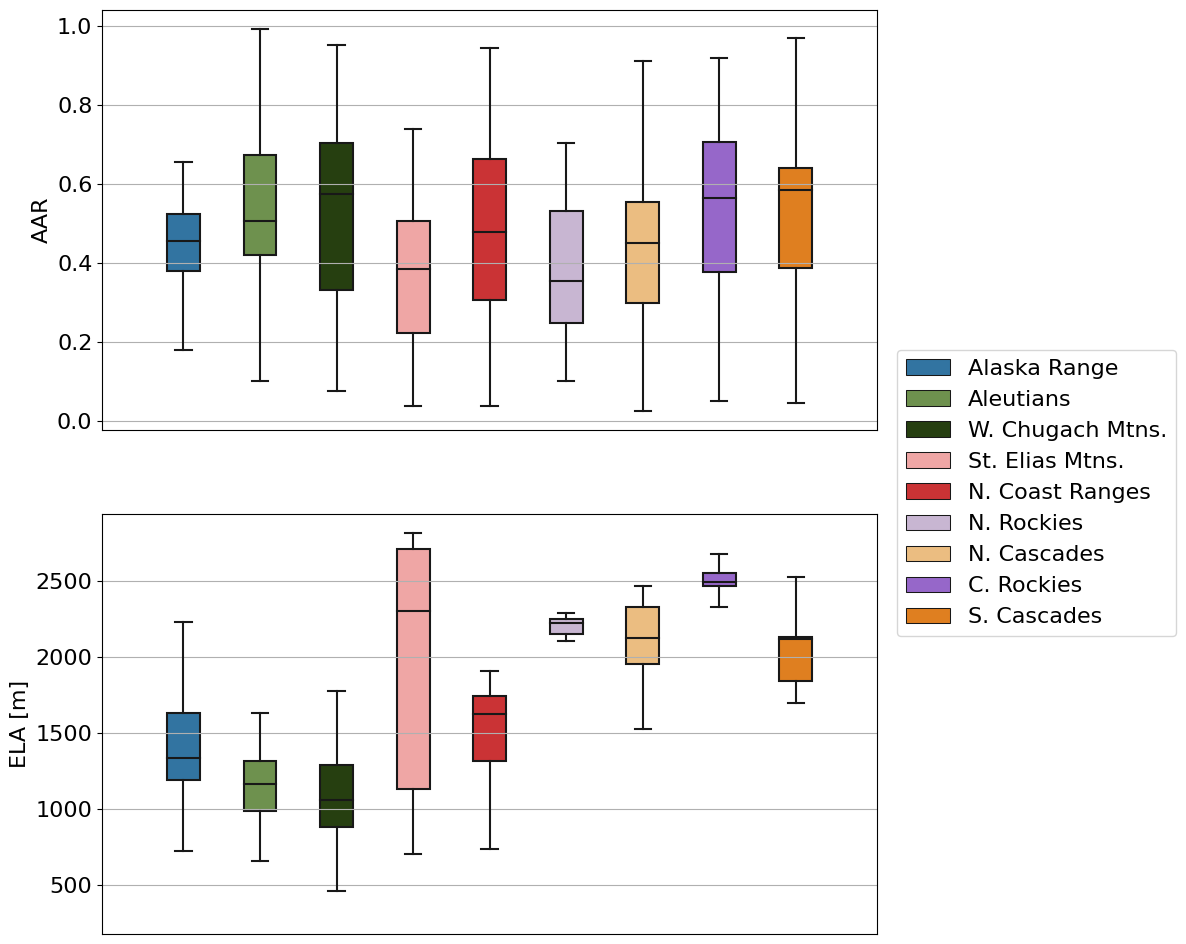

figure saved to file: /content/drive/MyDrive/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/figures/AARs_ELAs_boxplots.png


In [18]:
# -----Set up figure
plt.rcParams.update({'font.size':16, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(2, 1, figsize=(10,12))
# ax2 = ax[2].twinx()
xrange = [np.datetime64('2015-11-01'), np.datetime64('2022-12-01')]

# -----ELA time series
# add year column
elas['Year'] = elas['datetime'].values.astype('datetime64[Y]').astype(int) + 1970
# add subregion name and color columns to elas
elas[['Subregion', 'Color']] = '', ''
for o1region, o2region in unique_subregions.values:
    subregion_name, color = determine_subregion_name_color(o1region, o2region)
    elas.loc[(elas['O1Region']==o1region) & (elas['O2Region']==o2region), 'Subregion'] = subregion_name
    elas.loc[(elas['O1Region']==o1region) & (elas['O2Region']==o2region), 'Color'] = color
elas.sort_values(by=['O1Region', 'O2Region'], inplace=True)
# define palette for subregions
palette = elas[['O1Region', 'O2Region', 'Subregion', 'Color']].drop_duplicates()
palette = dict(palette[['Subregion', 'Color']].values)
# plot boxplots
bp1 = sns.boxplot(data=elas, x='Subregion', y='AAR', ax=ax[0], hue='Subregion',
                  palette=palette, fliersize=0, width=7)
bp2 = sns.boxplot(data=elas, x='Subregion', y='snowline_elevs_median_m', ax=ax[1], hue='Subregion',
                  palette=palette, fliersize=0, width=7)
# adjust axes
ax[0].set_ylabel('AAR')
ax[0].yaxis.grid()
ax[1].set_ylabel('ELA [m]')
ax[1].yaxis.grid()
# adjust legend
ax[0].legend(loc='center right', bbox_to_anchor=[1.2, -0.25, 0.2, 0.2])
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[1].get_legend().remove()
ax[0].set_xlim(-5, 13)
ax[1].set_xlim(-5, 13)
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax2.set_ylim(0, 3)
plt.show()

# save figure
fig_fn = os.path.join(figures_out_path, 'AARs_ELAs_boxplots.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('figure saved to file: ' + fig_fn)

## Plot geographic distribution of sites

In [19]:
study_sites_path = os.path.join(base_path, 'study-sites')

# load RGI O2 regions
rgi_o2_fn = os.path.join(base_path, 'GIS_data', 'RGI2000-v7.0-regions',
                         'RGI2000-v7.0-o2regions-Alaska-westernCanadaUS_clipped_to_country_outlines.shp')
rgi_o2 = gpd.read_file(rgi_o2_fn)
rgi_o2['o2region'] = [x[3:] for x in rgi_o2['o2region'].values]
rgi_o2[['o1region', 'o2region']] = rgi_o2[['o1region', 'o2region']].astype(float)

# grab all site names with ELA files
site_names = sorted(os.listdir(study_sites_path))
site_names = [x for x in site_names if os.path.exists(os.path.join(study_sites_path, x, 'ELAs'))]
site_names = [x for x in site_names if len(os.listdir(os.path.join(study_sites_path, x, 'ELAs')))>0]
print('Total number of sites = ', len(site_names))

# load aois
aois = gpd.GeoDataFrame()
for site_name in tqdm(site_names):
    aoi_fn = glob.glob(os.path.join(study_sites_path, site_name, 'AOIs', '*RGI*.shp'))[0]
    aoi = gpd.read_file(aoi_fn)
    aoi = aoi.to_crs('EPSG:4326')
    aois = pd.concat([aois, aoi])
aois[['O1Region', 'O2Region']] = aois[['O1Region', 'O2Region']].astype(float)

Total number of sites =  95


  0%|          | 0/95 [00:00<?, ?it/s]

In [ ]:
# set up figure
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
crs = 'EPSG:9822' # Albers Equal Conic projection

# reproject aois and rgi to crs
aois_reproj = aois.to_crs(crs)
# change name of area column for displaying
aois_reproj.rename(columns={'Area':'Area [km$^2$]'}, inplace=True)
# add geometry centroid coordinates
aois_reproj['centroid_x'] = [x.centroid.coords.xy[0][0] for x in aois_reproj['geometry']]
aois_reproj['centroid_y'] = [x.centroid.coords.xy[1][0] for x in aois_reproj['geometry']]
aois_reproj[['Subregion', 'Color']] = ['', '']
rgi_reproj = rgi_o2.to_crs(crs)

# iterate over subregions
for o1region, o2region in unique_subregions.values:
    # determine subregion name and color for plotting
    subregion_name, color = determine_subregion_name_color(o1region, o2region)
    # add columns to dataframe
    aois_reproj.loc[(aois_reproj['O1Region']==o1region) & (aois_reproj['O2Region']==o2region), 'Subregion'] = subregion_name
    aois_reproj.loc[(aois_reproj['O1Region']==o1region) & (aois_reproj['O2Region']==o2region), 'Color'] = color
    # plot subregion outlines
    rgi_subregion = rgi_reproj.loc[(rgi_reproj['o1region']==o1region) & (rgi_reproj['o2region']==o2region)]
    rgi_subregion.plot(ax=ax, facecolor=color, edgecolor=color, alpha=0.2)

# plot geometry centroids
kwargs = {'edgecolor': "w",
          'linewidth': 0.7,
          'linestyle':'-'}
sns.scatterplot(data=aois_reproj, x='centroid_x', y='centroid_y', hue='Subregion', size='Area [km$^2$]',
                sizes=(20,500), palette=dict(aois_reproj[['Subregion', 'Color']].drop_duplicates().values), **kwargs)

# adjust axes
ax.set_xlim(-5200000, -2000000)
ax.set_ylim(6700000, 10800000)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')

# add legend to figure
ax.legend(loc='upper right', bbox_to_anchor=[1.4, 0.5, 0.2, 0.2],
          title='Study sites (N=' + str(len(aois)) + ')')
# add basemap
ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldGrayCanvas, crs=crs, attribution=False)
plt.show()

# save figure
fig_fn = os.path.join(figures_out_path, 'ELA_study_sites.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('figure saved to file: ' + fig_fn)

## Plot locations of the example sites

NameError: ignored

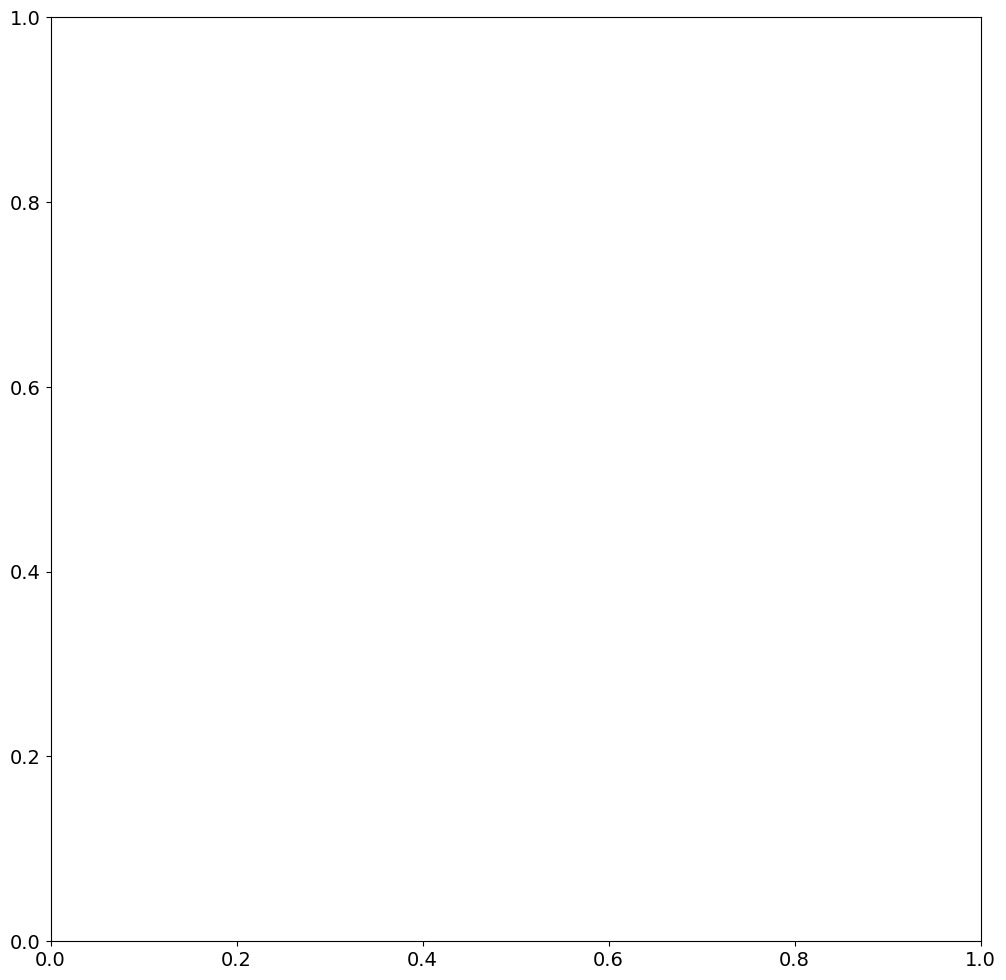

In [17]:
# set up figure
fig = plt.figure(figsize=(12,12), frameon=False)
ax = plt.subplot(1, 1, 1)

# plot markers for example glaciers
ids = ['RGI60-02.12483', 'RGI60-01.17774', 'RGI60-02.03578']
for id in ids:
    aoi_example = aois_reproj.loc[aois_reproj['RGIId']==id]
    color = aoi_example['Color'].values[0]
    ax.plot(aoi_example['centroid_x'].values, aoi_example['centroid_y'].values, '*',
            markerfacecolor=color, markeredgecolor=color, markersize=20, label=id)

# plot o2 regions
for o1region, o2region in unique_subregions.values:
    # determine subregion name and color for plotting
    subregion_name, color = determine_subregion_name_color(o1region, o2region)
    # plot subregion outlines
    rgi_subregion = rgi_reproj.loc[(rgi_reproj['o1region']==o1region) & (rgi_reproj['o2region']==o2region)]
    rgi_subregion.plot(ax=ax, facecolor=color, edgecolor=color, alpha=0.2)

# adjust axes
ax.set_xlim(-5200000, -2500000)
ax.set_ylim(6700000, 10200000)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')

# add legend
ax.legend(loc='center right', bbox_to_anchor=[1.25, 0.5, 0.2, 0.2])

plt.show()

# save figure
fig_fn = os.path.join(figures_out_path, 'ELA_adjustment_example_site_locations.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('figure saved to file: ' + fig_fn)

## Plot best model feature importances

In [ ]:
# load best model feature importances
importances_fn = os.path.join(base_path, 'snow-cover-mapping-application',
                              'inputs-outputs', 'best_model_ELAs_feature_importances.csv')
importances = pd.read_csv(importances_fn)
columns = list(importances.keys())
# calculate medians and IQRs for each variable
medians = [np.median(importances[column].values) for column in columns]
iqrs = [iqr(importances[column].values) for column in columns]

# plot
plt.rcParams.update({'font.size':18, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(1,1, figsize=(10,6))
props = {'linewidth': 2, 'color': 'k'}
# plot bars for medians
x = np.arange(0, len(medians))
b = ax.bar(x, medians, yerr=iqrs, edgecolor='k', error_kw={'elinewidth':3}, linewidth=2)
# change bar colors
colors = ['#800000', '#008080', '#ffa500', '#febfcb', '#00ffff']
for i, bar in enumerate(b):
    bar.set_facecolor(colors[i])

# ax.grid()
ax.set_xticks(np.arange(0,len(columns)))
ax.set_xticklabels(['Area', 'Z$_{med}$', 'Slope', 'Aspect', 'L$_{max}$'])
ax.set_ylabel('Importance')
plt.show()

# save figure
fig_fn = os.path.join(figures_out_path, 'ELA_best_model_feature_importances.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('figure saved to file: ' + fig_fn)